# Fehlerprotokolle im Projekt

Diese Analyse beschäftigt sich mit der Fehlerprotokolle, welche über den Analysezeitraum im Projekt aufgetreten sind. Diese unterteilen sich in Fehlerprotokolle des Entwicklungs- und des Produktionssystems.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dabei werden die Fehlerprotokolle pro Tag und System addiert.

In [1]:
import shared.paths as paths
import shared.locals as locals
from datetime import datetime, timedelta
from helpers.config import Configuration
from database.database import Database
from database.models import ErrorLog

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

start_date = datetime.utcfromtimestamp(config.start_timestamp)
limit_date = datetime.utcfromtimestamp(config.limit_timestamp)
error_threshold = 80

delta = limit_date - start_date
days = [(start_date+timedelta(days=i)).date() for i in range(delta.days + 1)]
years = {day.year for day in days}

min_day = min({datetime.utcfromtimestamp(log.timestamp).date() for log in database.all(ErrorLog.LABEL)})
fitted_days = days[days.index(min_day):]
error_result = {day: {"development": 0, "production": 0} for day in fitted_days}

for errorlog in database.all(ErrorLog.LABEL):
    date = datetime.utcfromtimestamp(errorlog.timestamp).date()
    error_result[date][errorlog.account] += 1

## Visualisierung der Daten

Im zweiten Schritt werden die Daten anhand von zwei Liniendiagrammen für die jeweiligen Umgebungen dargestellt.

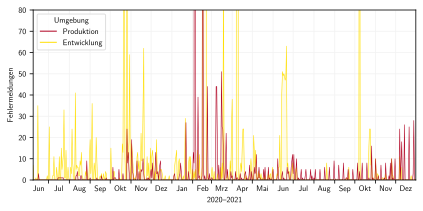

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 3))

dates = list(error_result.keys())
error_result_prod = [result["production"] for result in error_result.values()]
error_result_dev = [result["development"] for result in error_result.values()]

ax.plot(dates, error_result_prod, color=locals.ERROR_COLOR_RED, label="Produktion", linewidth=.5, zorder=2)
ax.fill_between(dates, error_result_prod, color=locals.ERROR_COLOR_RED, alpha=0.1)
ax.plot(dates, error_result_dev, color=locals.ERROR_COLLOR_YELLOW, label="Entwicklung", linewidth=.5, zorder=1)
ax.fill_between(dates, error_result_dev, color=locals.ERROR_COLLOR_YELLOW, alpha=0.1)

legend = ax.legend(loc="upper left", title="Umgebung", edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_linewidth(1.0)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=True)

ax.margins(x=0)
ax.set_ylim([0,error_threshold])
ax.set_xlabel("2020–2021")
ax.set_ylabel("Fehlermeldungen")
ax.yaxis.set_major_locator(mticker.MultipleLocator(base=10))
ax.grid(color=locals.GRID_GRAY)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## Erstellung der Wertetabelle

Als letzter Schritt wird die entsprechende Wertetabelle angelegt.

In [3]:
from IPython.display import display, HTML, Markdown
from tabulate import tabulate

display(Markdown("**Wertetabelle**"))

table_headers = ["Datum", "Fehlermeldungen (Produktion)", "Fehlermeldungen (Entwicklung)"]
table_rows = []

for day in fitted_days:
    table_rows.append([
        day.strftime("%d.%m.%Y"),
        error_result[day]["production"],
        error_result[day]["development"]
    ])

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))

**Wertetabelle**

Datum,Fehlermeldungen (Produktion),Fehlermeldungen (Entwicklung)
08.06.2020,0,7
09.06.2020,0,0
10.06.2020,0,0
11.06.2020,0,0
12.06.2020,0,1
13.06.2020,0,0
14.06.2020,0,0
15.06.2020,0,35
16.06.2020,3,0
17.06.2020,0,0
